In [21]:
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
from ngboost import NGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#Load Boston housing dataset
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
Y = raw_df.values[1::2, 2]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

ngb = NGBRegressor().fit(X_train, Y_train)
Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

# test Mean Squared Error
test_MSE_ngb = mean_squared_error(Y_preds, Y_test)
print('NGB Test MSE', test_MSE_ngb)

# test Negative Log Likelihood
test_NLL = -Y_dists.logpdf(Y_test).mean()
print('Test NLL', test_NLL)


[iter 0] loss=3.6201 val_loss=0.0000 scale=1.0000 norm=6.6257
[iter 100] loss=2.6889 val_loss=0.0000 scale=2.0000 norm=4.9218
[iter 200] loss=2.1723 val_loss=0.0000 scale=2.0000 norm=3.5271
[iter 300] loss=1.9476 val_loss=0.0000 scale=1.0000 norm=1.5561
[iter 400] loss=1.8292 val_loss=0.0000 scale=1.0000 norm=1.4508
NGB Test MSE 6.827682147188644
Test NLL 2.6578473680711956


In [22]:
len(Y_preds)

102

In [23]:
sampled = Y_dists.sample(100)[0]
sampled

array([33.50390912, 33.32173509,  3.0963037 , 21.49716915, 22.66030202,
       20.8567441 , 21.43548531, 23.23202855, 18.58570453, 26.97337897,
       43.86710242, 22.44779653, 17.13503729, 15.91384534, 12.99446203,
       18.36826907, 14.5383668 , 25.41509722, 22.84738445, 21.80432621,
       13.33281677, 19.89283658, 24.67257091, 16.01727641, 30.17506929,
       46.01042869, 32.5910251 ,  9.17509812, 19.34270122, 24.06737161,
       27.58436577,  6.64513659, 22.01040989, 16.69587509, 11.46778994,
       13.95470353, 27.03159858, 21.97255638, 21.27718124, 46.46988944,
       11.58567468, 12.18059409, 23.69188399, 13.9475079 , 34.47478982,
       15.00346177, 25.42687038, 18.79829981, 16.08299193, 27.97376077,
       25.52211584, 43.17855874, 22.41936694, 18.76621799, 23.05584792,
       13.61872621, 32.72460295, 19.70852131, 22.28829392, 36.72673306,
       13.88859415, 23.38702576, 43.67180902, 29.27343839, 21.51797544,
       33.18224936, 19.20168212,  9.00591471, 18.48452065, 42.57

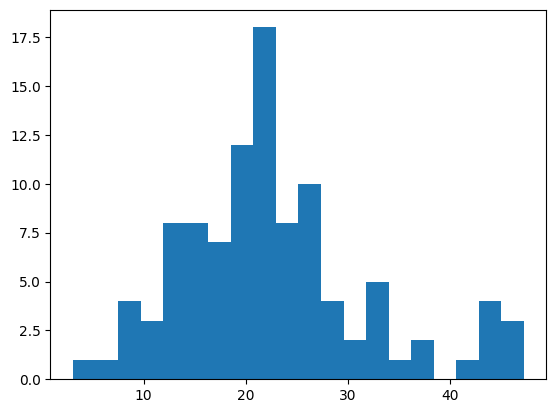

In [24]:
# plot hist for sampled
import matplotlib.pyplot as plt

plt.hist(sampled, bins=20)
plt.show()

In [25]:
from sklearn.model_selection import GridSearchCV

# Setting up parameter grid for XGBoost fine-tuning
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the XGBoost regressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Setup the grid search
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1
)

# Perform grid search
grid_search.fit(X_train, Y_train)

# Best estimator
best_xgb = grid_search.best_estimator_

# Predicting with the best estimator
Y_xgb_preds = best_xgb.predict(X_test)

# test Mean Squared Error
test_MSE_ngb = mean_squared_error(Y_preds, Y_test)
print('NGB Test MSE', test_MSE_ngb)

# Test Mean Squared Error for XGBoost
test_MSE_xgb = mean_squared_error(Y_xgb_preds, Y_test)
print('XGBoost Best Test MSE:', test_MSE_xgb)
print('Best parameters:', grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
NGB Test MSE 6.827682147188644
XGBoost Best Test MSE: 6.271459637863312
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


In [31]:
from sklearn.tree import DecisionTreeRegressor
from ngboost.distns import Normal
from ngboost.scores import LogScore

# Setting up parameter grid for NGBoost fine-tuning
param_grid = {
    'n_estimators': [200, 500],
    'learning_rate': [0.005, 0.01, 0.05],
    'minibatch_frac': [1.0, 0.5],
    'col_sample': [1.0, 0.8],
}

# Initialize the NGBoost regressor
ngb = NGBRegressor()

# Setup the grid search
grid_search_ngb = GridSearchCV(
    estimator=ngb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1
)

# Perform grid search
grid_search_ngb.fit(X_train, Y_train)

# Best estimator
best_ngb = grid_search_ngb.best_estimator_

# Predicting with the best estimator
Y_ngb_preds = best_ngb.predict(X_test)

# Test Mean Squared Error for NGBoost
test_MSE_ngb = mean_squared_error(Y_ngb_preds, Y_test)
print('NGBoost Best Test MSE:', test_MSE_ngb)
print('Best parameters:', grid_search_ngb.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[iter 0] loss=3.5953 val_loss=0.0000 scale=1.0000 norm=6.4366
[iter 100] loss=3.1439 val_loss=0.0000 scale=2.0000 norm=8.4159
[iter 0] loss=3.6361 val_loss=0.0000 scale=1.0000 norm=6.7850
[iter 100] loss=3.0937 val_loss=0.0000 scale=2.0000 norm=7.6785
[iter 0] loss=3.6349 val_loss=0.0000 scale=1.0000 norm=6.8405
[iter 100] loss=3.1235 val_loss=0.0000 scale=2.0000 norm=8.0532
[iter 0] loss=3.5865 val_loss=0.0000 scale=1.0000 norm=6.3823
[iter 100] loss=3.1219 val_loss=0.0000 scale=2.0000 norm=8.1910
[iter 0] loss=3.6444 val_loss=0.0000 scale=1.0000 norm=6.6872
[iter 100] loss=3.0674 val_loss=0.0000 scale=2.0000 norm=7.4053
[iter 0] loss=3.5953 val_loss=0.0000 scale=1.0000 norm=6.4366
[iter 100] loss=3.1439 val_loss=0.0000 scale=2.0000 norm=8.4159
[iter 200] loss=2.7471 val_loss=0.0000 scale=2.0000 norm=5.2482
[iter 300] loss=2.4260 val_loss=0.0000 scale=2.0000 norm=4.0674
[iter 400] loss=2.1809 val_loss=0.0000 scale=1.0000 no